In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')

df = df.set_index('Date')  
df.index = pd.to_datetime(df.index)
df = df[df.index >= '2021-04-01']

target_col = 'SPY_vol_5d'
# exog_cols = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
exog_cols = ['VIX_log','Overnight Rate','1-Month Rate','3-Month Rate','CPI_pct_change','PPI_pct_change','Unemployment Rate','GDP_pct_change']

# Prepare data for ARIMAX
model_data = df[[target_col] + exog_cols].copy().dropna()

endog = model_data[target_col]
exog = model_data[exog_cols]

print(f"Final dataset shape: {model_data.shape}")
print(f"Date range: {model_data.index[0]} to {model_data.index[-1]}")
print(f"Endogenous variable: {target_col}")
print(f"Exogenous variables: {exog_cols}")

Final dataset shape: (1168, 9)
Date range: 2021-04-01 00:00:00 to 2025-09-01 00:00:00
Endogenous variable: SPY_vol_5d
Exogenous variables: ['VIX_log', 'Overnight Rate', '1-Month Rate', '3-Month Rate', 'CPI_pct_change', 'PPI_pct_change', 'Unemployment Rate', 'GDP_pct_change']


In [2]:
def fit_arimax_historical(endog, exog, test_size=0.2, order=(1,0,0)):
    """
    Fit ARIMAX model and test on historical data.
    
    Parameters:
    endog (pd.Series): Endogenous variable (target time series).
    exog (pd.DataFrame): Exogenous variables.
    test_size (float): Proportion of data to use for testing.
    order (tuple): ARIMA order (p,d,q).
    
    Returns:
    tuple: (fitted_model, forecasts_df, metrics)
    """
    
    # Split data into train and test (chronological split for time series)
    split_idx = int(len(endog) * (1 - test_size))
    
    endog_train = endog.iloc[:split_idx]
    endog_test = endog.iloc[split_idx:]
    exog_train_raw = exog.iloc[:split_idx]
    exog_test_raw = exog.iloc[split_idx:]
    
    print(f"Training period: {endog.index[0]} to {endog.index[split_idx-1]}")
    print(f"Testing period: {endog.index[split_idx]} to {endog.index[-1]}")
    print(f"Train samples: {len(endog_train)}, Test samples: {len(endog_test)}")
    print(f"Number of exogenous variables: {exog.shape[1]}")
    print(f"ARIMA order: {order}")
    
    scaler = StandardScaler()

    exog_train = scaler.fit_transform(exog_train_raw)
    exog_train = pd.DataFrame(exog_train, 
                                    index=exog_train_raw.index, 
                                    columns=exog_cols)
    
    # Initialize and fit ARIMAX model
    try:
        model = SARIMAX(
            endog_train,
            exog=exog_train,
            order=order,
            trend='c',
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        fitted_model = model.fit(disp=False)
        print("ARIMAX model fitted successfully!")

        # Print model summary
        print(f"\nModel AIC: {fitted_model.aic:.4f}")
        print(f"Model BIC: {fitted_model.bic:.4f}")

    except Exception as e:
        print(f"Model fitting failed: {e}")
        return None, None, None
        
    
    exog_test = scaler.transform(exog_test_raw)
    exog_test = pd.DataFrame(exog_test, 
                                    index=exog_test_raw.index, 
                                    columns=exog_cols)
    # Make predictions
    try:
        train_pred = fitted_model.fittedvalues

        forecast_result = fitted_model.get_forecast(
            steps=len(endog_test),
            exog=exog_test
        )

        test_pred = forecast_result.predicted_mean
        confidence_int = forecast_result.conf_int()

        # Create results DataFrame
        forecasts_df = pd.DataFrame({
            'Actual': endog_test.values,
            'Forecast': test_pred.values,
            'Lower_CI': confidence_int.iloc[:, 0].values,
            'Upper_CI': confidence_int.iloc[:, 1].values
        }, index=endog_test.index)

        #check nan
        print("Zeros in actual:", sum(1 for x in endog_test if x == 0))

        # # Remove or handle zero values
        # clean_data = df[df['actual'] != 0]
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(endog_test, test_pred))
        mae = mean_absolute_error(endog_test, test_pred)
        mape = np.mean(np.abs((endog_test - test_pred) / endog_test)) * 100
        
        metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
        print(f"\n=== MODEL PERFORMANCE ===")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"MAPE: {mape:.2f}%")
        
        return fitted_model, forecasts_df, metrics
        
    except Exception as e:
        print(f"Prediction failed: {e}")
        return fitted_model, None, None

def plot_historical_results(train_data, forecasts_df, target_col):
    """
    Plot training data, actual test values, and forecasts with confidence intervals.
    
    Parameters:
    train_data (pd.Series): Training data (endogenous variable)
    forecasts_df (pd.DataFrame): DataFrame with actual and forecasted values
    target_col (str): Name of the target column
    """
    plt.figure(figsize=(14, 8))
    
    # Plot training data
    plt.plot(train_data.index, train_data, 
             label='Training Data', color='blue', alpha=0.7)
    
    # Plot actual test values
    plt.plot(forecasts_df.index, forecasts_df['Actual'], 
             label='Actual Test', color='green', linewidth=2)
    
    # Plot forecasts
    plt.plot(forecasts_df.index, forecasts_df['Forecast'], 
             label='ARIMAX Forecast', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals if available
    if 'Lower_CI' in forecasts_df.columns and 'Upper_CI' in forecasts_df.columns:
        plt.fill_between(forecasts_df.index, 
                        forecasts_df['Lower_CI'], 
                        forecasts_df['Upper_CI'], 
                        alpha=0.3, color='red', label='95% Confidence Interval')
    
    plt.title('ARIMAX Model: Historical Forecast vs Actual', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



Training period: 2021-04-01 00:00:00 to 2024-10-14 00:00:00
Testing period: 2024-10-15 00:00:00 to 2025-09-01 00:00:00
Train samples: 934, Test samples: 234
Number of exogenous variables: 8
ARIMA order: (1, 0, 0)
ARIMAX model fitted successfully!

Model AIC: -7398.1662
Model BIC: -7344.9437
Zeros in actual: 0

=== MODEL PERFORMANCE ===
RMSE: 0.019641
MAE: 0.010007
MAPE: nan%


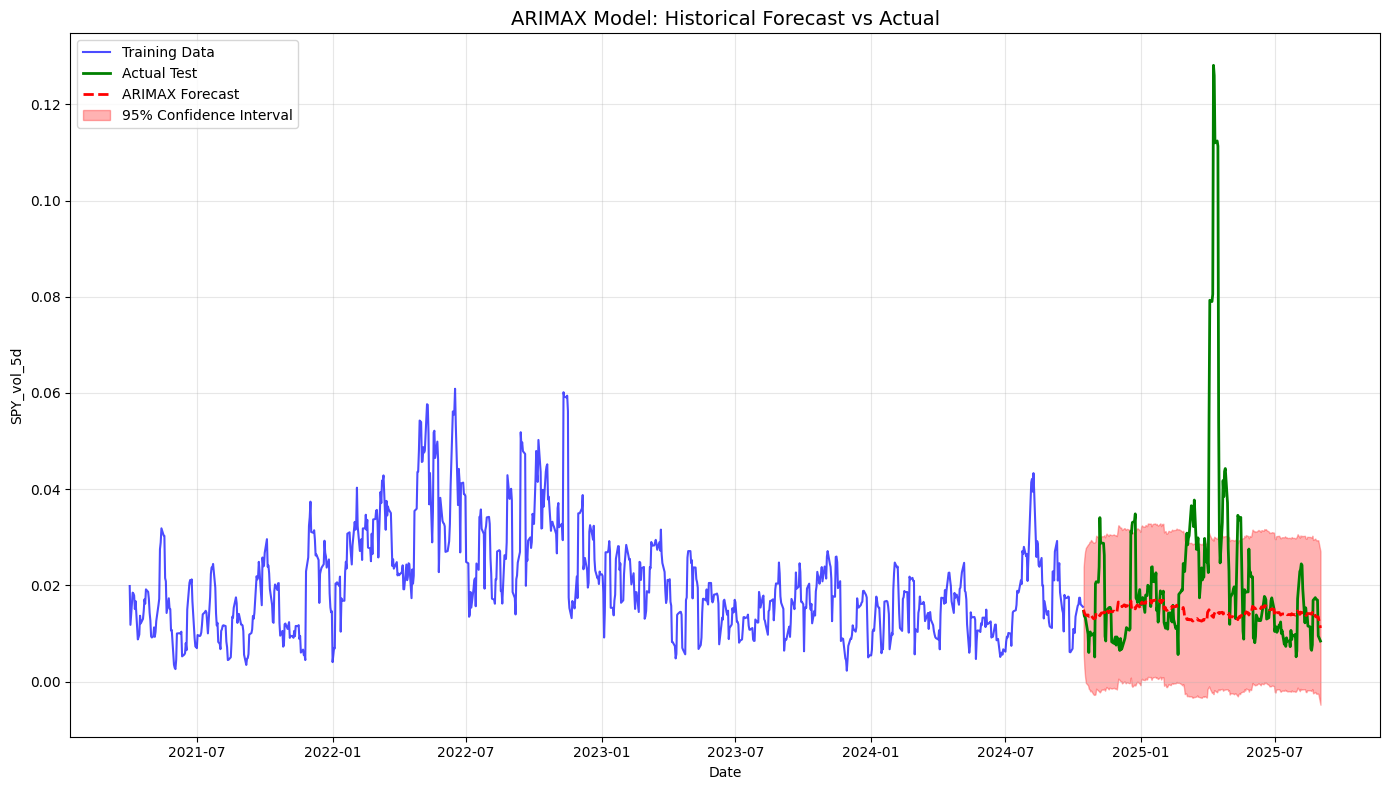

In [3]:
# Run the historical backtest with ARIMAX
model, forecasts, metrics = fit_arimax_historical(
    endog=endog,
    exog=exog,
    test_size=0.2,
    order=(1,0,0)
)

# Plot results
plot_historical_results(endog.iloc[:int(len(endog) * 0.8)], forecasts, target_col)



In [4]:
def time_series_cross_validation(endog, exog, n_splits=5, test_size=0.2, order=(1,0,0), min_train_size=None):
    """
    Perform time series cross-validation for ARIMAX model.
    
    Parameters:
    endog (pd.Series): Endogenous variable (target time series)
    exog (pd.DataFrame): Exogenous variables
    n_splits (int): Number of CV folds
    test_size (float): Proportion of data to use for testing in each fold
    order (tuple): ARIMA order (p,d,q)
    min_train_size (int): Minimum training size for first fold (optional)
    
    Returns:
    dict: Cross-validation results with metrics and predictions
    """
    from sklearn.model_selection import TimeSeriesSplit
    import warnings
    warnings.filterwarnings('ignore')
    
    # Set minimum training size to 30% for training
    if min_train_size is None:
        min_train_size = int(len(endog) * 0.3)
    
    # Create time series split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Store results
    cv_results = {
        'fold_metrics': [],
        'fold_predictions': [],
        'fold_models': [],
        'overall_metrics': {}
    }
    
    print(f"=== TIME SERIES CROSS-VALIDATION ===")
    print(f"Total samples: {len(endog)}")
    print(f"Number of folds: {n_splits}")
    print(f"ARIMA order: {order}")
    print(f"Minimum training size: {min_train_size}")
    print("=" * 50)
    
    fold_num = 1
    
    for train_idx, test_idx in tscv.split(endog):
        # Ensure minimum training size
        if len(train_idx) < min_train_size:
            print(f"Skipping fold {fold_num}: insufficient training data ({len(train_idx)} < {min_train_size})")
            fold_num += 1
            continue
            
        print(f"\n--- FOLD {fold_num} ---")
        print(f"Train: {endog.index[train_idx[0]]} to {endog.index[train_idx[-1]]} ({len(train_idx)} samples)")
        print(f"Test:  {endog.index[test_idx[0]]} to {endog.index[test_idx[-1]]} ({len(test_idx)} samples)")
        
        # Split data
        endog_train = endog.iloc[train_idx]
        endog_test = endog.iloc[test_idx]
        exog_train = exog.iloc[train_idx]
        exog_test = exog.iloc[test_idx]
        
        try:
            # Fit ARIMAX model
            model = SARIMAX(
                endog_train,
                exog=exog_train,
                order=order,
                trend='c',
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            
            fitted_model = model.fit(disp=False)
            
            # Make predictions
            forecast_result = fitted_model.get_forecast(
                steps=len(endog_test),
                exog=exog_test
            )
            
            test_pred = forecast_result.predicted_mean
            confidence_int = forecast_result.conf_int()
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(endog_test, test_pred))
            mae = mean_absolute_error(endog_test, test_pred)
            
            # Handle MAPE calculation (avoid division by zero)
            mape_values = np.abs((endog_test - test_pred) / endog_test)
            mape_values = mape_values[~np.isinf(mape_values)]  # Remove infinite values
            mape = np.mean(mape_values) * 100 if len(mape_values) > 0 else np.nan
            
            # Store fold results
            fold_metrics = {
                'fold': fold_num,
                'train_size': len(train_idx),
                'test_size': len(test_idx),
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic
            }
            
            fold_predictions = pd.DataFrame({
                'Actual': endog_test.values,
                'Forecast': test_pred.values,
                'Lower_CI': confidence_int.iloc[:, 0].values,
                'Upper_CI': confidence_int.iloc[:, 1].values,
                'Fold': fold_num
            }, index=endog_test.index)
            
            cv_results['fold_metrics'].append(fold_metrics)
            cv_results['fold_predictions'].append(fold_predictions)
            cv_results['fold_models'].append(fitted_model)
            
            print(f"RMSE: {rmse:.6f}")
            print(f"MAE: {mae:.6f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"AIC: {fitted_model.aic:.4f}")
            
        except Exception as e:
            print(f"Fold {fold_num} failed: {e}")
            fold_num += 1
            continue
        
        fold_num += 1
    
    # Calculate overall metrics
    if cv_results['fold_metrics']:
        metrics_df = pd.DataFrame(cv_results['fold_metrics'])
        
        cv_results['overall_metrics'] = {
            'mean_RMSE': metrics_df['RMSE'].mean(),
            'std_RMSE': metrics_df['RMSE'].std(),
            'mean_MAE': metrics_df['MAE'].mean(),
            'std_MAE': metrics_df['MAE'].std(),
            'mean_MAPE': metrics_df['MAPE'].mean(),
            'std_MAPE': metrics_df['MAPE'].std(),
            'mean_AIC': metrics_df['AIC'].mean(),
            'std_AIC': metrics_df['AIC'].std(),
            'mean_BIC': metrics_df['BIC'].mean(),
            'std_BIC': metrics_df['BIC'].std()
        }
        
        print(f"\n=== OVERALL CROSS-VALIDATION RESULTS ===")
        print(f"Mean RMSE: {cv_results['overall_metrics']['mean_RMSE']:.6f} ± {cv_results['overall_metrics']['std_RMSE']:.6f}")
        print(f"Mean MAE:  {cv_results['overall_metrics']['mean_MAE']:.6f} ± {cv_results['overall_metrics']['std_MAE']:.6f}")
        # print(f"Mean MAPE: {cv_results['overall_metrics']['mean_MAPE']:.2f}% ± {cv_results['overall_metrics']['std_MAPE']:.2f}%")
        print(f"Mean AIC:  {cv_results['overall_metrics']['mean_AIC']:.4f} ± {cv_results['overall_metrics']['std_AIC']:.4f}")
        print(f"Mean BIC:  {cv_results['overall_metrics']['mean_BIC']:.4f} ± {cv_results['overall_metrics']['std_BIC']:.4f}")
    
    return cv_results


In [5]:
# Run cross-validation
print("Running Time Series Cross-Validation for ARIMAX Model...")
cv_results = time_series_cross_validation(
    endog=endog,
    exog=exog,
    n_splits=5,
    order=(1,0,0),
    min_train_size=200
)


Running Time Series Cross-Validation for ARIMAX Model...
=== TIME SERIES CROSS-VALIDATION ===
Total samples: 1168
Number of folds: 5
ARIMA order: (1, 0, 0)
Minimum training size: 200
Skipping fold 1: insufficient training data (198 < 200)

--- FOLD 2 ---
Train: 2021-04-01 00:00:00 to 2022-09-26 00:00:00 (392 samples)
Test:  2022-09-27 00:00:00 to 2023-06-20 00:00:00 (194 samples)
RMSE: 0.013919
MAE: 0.011309
MAPE: nan%
AIC: -3031.9679

--- FOLD 3 ---
Train: 2021-04-01 00:00:00 to 2023-06-20 00:00:00 (586 samples)
Test:  2023-06-21 00:00:00 to 2024-03-14 00:00:00 (194 samples)
RMSE: 0.006786
MAE: 0.005713
MAPE: nan%
AIC: -4497.7241

--- FOLD 4 ---
Train: 2021-04-01 00:00:00 to 2024-03-14 00:00:00 (780 samples)
Test:  2024-03-15 00:00:00 to 2024-12-06 00:00:00 (194 samples)
RMSE: 0.009928
MAE: 0.007014
MAPE: nan%
AIC: -6109.5220

--- FOLD 5 ---
Train: 2021-04-01 00:00:00 to 2024-12-06 00:00:00 (974 samples)
Test:  2024-12-09 00:00:00 to 2025-09-01 00:00:00 (194 samples)
RMSE: 0.021501
MA

In [6]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             SPY_vol_5d   No. Observations:                  934
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3710.083
Date:                Tue, 21 Oct 2025   AIC                          -7398.166
Time:                        11:51:16   BIC                          -7344.944
Sample:                             0   HQIC                         -7377.870
                                - 934                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0034      0.000      8.441      0.000       0.003       0.004
VIX_log               0.0001   8.91e-05      1.657      0.098    -2.7e-05       0.000
Overnight Rate       -0.0174      0.005     -3.473      0.001      -0.027      -0.008
1-Month Rate         -0.0104      0.010     -1.083      0.279      -0.029       0.008
3-Month Rate          0.0264      0.007      3.525      0.000       0.012       0.041
CPI_pct_change        0.0024      0.001      1.980      0.048    2.48e-05       0.005
PPI_pct_change       -0.0011      0.001     -0.983      0.326      -0.003       0.001
Unemployment Rate    -0.0021      0.001     -1.375      0.169      -0.005       0.001
GDP_pct_change        0.0001      0.001      0.086      0.931      -0.002       0.003
ar.L1                 0.8305      0.016     53.579      0.000       0.800       0.861
sigma2             2.054e-05   4.86e-07     42.244      0.000    1.96e-05    2.15e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):              2870.37
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# Calculate R² (Coefficient of Determination) for the ARIMAX model
from sklearn.metrics import r2_score

def calculate_r2_metrics(model, endog_train, endog_test, exog_test, forecasts_df=None):
    """
    Calculate R² for both training and test data.
    
    Parameters:
    model: Fitted ARIMAX model
    endog_train: Training endogenous data
    endog_test: Test endogenous data  
    exog_test: Test exogenous data
    forecasts_df: DataFrame with forecasts (optional)
    
    Returns:
    dict: R² metrics for training and test data
    """
    
    # Calculate R² for training data (using fitted values)
    train_fitted = model.fittedvalues
    train_r2 = r2_score(endog_train, train_fitted)
    
    # Calculate R² for test data
    if forecasts_df is not None:
        # Use forecasts from the provided DataFrame
        test_pred = forecasts_df['Forecast']
        test_r2 = r2_score(endog_test, test_pred)
    else:
        # Generate forecasts if not provided
        forecast_result = model.get_forecast(steps=len(endog_test), exog=exog_test)
        test_pred = forecast_result.predicted_mean
        test_r2 = r2_score(endog_test, test_pred)
    
    # Calculate additional metrics
    train_ss_res = np.sum((endog_train - train_fitted) ** 2)
    train_ss_tot = np.sum((endog_train - np.mean(endog_train)) ** 2)
    
    test_ss_res = np.sum((endog_test - test_pred) ** 2)
    test_ss_tot = np.sum((endog_test - np.mean(endog_test)) ** 2)
    
    r2_metrics = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_ss_res': train_ss_res,
        'train_ss_tot': train_ss_tot,
        'test_ss_res': test_ss_res,
        'test_ss_tot': test_ss_tot
    }
    
    return r2_metrics

# Calculate R² for the main model (single split)
if 'model' in locals() and model is not None:
    # Get training and test data from the single split
    split_idx = int(len(endog) * 0.8)
    endog_train_single = endog.iloc[:split_idx]
    endog_test_single = endog.iloc[split_idx:]
    exog_test_single = exog.iloc[split_idx:]
    
    r2_metrics_single = calculate_r2_metrics(
        model=model,
        endog_train=endog_train_single,
        endog_test=endog_test_single,
        exog_test=exog_test_single,
        forecasts_df=forecasts
    )
    
    print("=== R² (COEFFICIENT OF DETERMINATION) ANALYSIS ===")
    print(f"Training R²: {r2_metrics_single['train_r2']:.6f}")
    print(f"Test R²:     {r2_metrics_single['test_r2']:.6f}")

else:
    print("Model not available. Please run the model fitting first.")


=== R² (COEFFICIENT OF DETERMINATION) ANALYSIS ===
Training R²: 0.816481
Test R²:     -0.145840
